In [63]:
import sys
sys.path.insert(0, '../Triangulation/')
sys.path.insert(0, '../network_datasets')



In [64]:
from Triangulation import *
from Neural_network import *
import numpy as np

from itertools import permutations
from matplotlib import pyplot as plt
from matplotlib.pyplot import triplot
from numpy import pi,sin,cos,tan,sqrt
from IPython.core.debugger import Tracer

import triangle as tri
import triangle
import triangle.plot as plot


from scipy.spatial import ConvexHull
from matplotlib.path import Path

import pickle



import torch
import torch.optim as optim

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F



import cTimer as ctimer
import time
from timeit import default_timer as timer
import pickle

%matplotlib inline




In [65]:


        
def load_network(filename):
    path=os.path.join('../network_datasets/',filename)
        
    with open(path,'rb') as input:
        net=pickle.load(input)
        
    net.eval()
    return net


def save_network(filename,net):
    path=os.path.join('../network_datasets/',filename)

    with open(path,'wb') as output:
        pickle.dump(net,output)

In [66]:
#load polygon dataset

Polygons,quality_matrices=load_dataset('6_polygons.pkl'),load_dataset('6_polygons_qualities_min.pkl')

In [67]:
# Testing data are usually 20 percent of the whole

nb_of_points=6
nb_of_contours=int(Polygons.shape[0])

nb_test_data=int(0.2*Polygons.shape[0])
nb_training_data=int(Polygons.shape[0])-nb_test_data
Polygons.shape[0]

12000

In [68]:
# Reshaping data for NN
Polygons_reshaped=[]



for i in range(nb_of_contours):
    Polygons_reshaped.append(Polygons[i].reshape(2*nb_of_points))

Polygons_reshaped=np.array(Polygons_reshaped) 

In [69]:
# Organizing data 
training_data = Polygons_reshaped[:nb_training_data]
testing_data  = Polygons_reshaped[nb_training_data:]

training_labels=quality_matrices[:nb_training_data]
testing_labels=quality_matrices[nb_training_data:]


In [70]:
# Convert to pytorch tensors

x_tensor=torch.from_numpy(training_data).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(testing_data).type(torch.FloatTensor)


y_tensor=torch.from_numpy(training_labels).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(testing_labels).type(torch.FloatTensor)


# Convert to pytorch variables
x_variable=Variable(x_tensor)
x_variable_test=Variable(x_tensor_test)



y_variable=Variable(y_tensor)
y_variable=y_variable.resize(nb_training_data,nb_of_points*nb_of_points)


y_variable_test=Variable(y_tensor_test)
y_variable_test=y_variable_test.resize(nb_test_data,nb_of_points*nb_of_points)


In [71]:
# NN
my_net=Net(2*nb_of_points,nb_of_points*nb_of_points,nb_of_hidden_layers=3,
           nb_of_hidden_nodes=2*(nb_of_points**2),batch_normalization=True)


In [72]:
# Optimization method and loss function
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3,weight_decay=0.2)

loss_func = torch.nn.MSELoss(size_average=False)  

In [90]:
# Copying data to GPU
if  torch.cuda.is_available():
    my_net.cuda()
    loss_func.cuda()
    x_variable , y_variable = x_variable.cuda(), y_variable.cuda()
    x_variable_test , y_variable_test = x_variable_test.cuda(), y_variable_test.cuda()
    print("cuda activated")

cuda activated


In [91]:
# Training data



nb_of_epochs=1500
batch_size=int(x_variable.shape[0]/100)
# Train the network #
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.item()
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    
    my_net.eval()
    test_loss=loss_func(my_net(x_variable_test),y_variable_test).item()
    my_net.train()
    print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 0.11227750425537428 Test Loss: 0.055323333740234376
Epoch: 1 Training Loss: 0.08545830344160397 Test Loss: 0.06332272211710611
Epoch: 2 Training Loss: 0.07569884618123372 Test Loss: 0.06293265024820964
Epoch: 3 Training Loss: 0.07333379189173381 Test Loss: 0.06371010462443034
Epoch: 4 Training Loss: 0.07228894352912903 Test Loss: 0.06426785786946615
Epoch: 5 Training Loss: 0.0717785225311915 Test Loss: 0.06505860010782878
Epoch: 6 Training Loss: 0.07150682578484217 Test Loss: 0.06573928833007812
Epoch: 7 Training Loss: 0.0714383269349734 Test Loss: 0.0660732396443685
Epoch: 8 Training Loss: 0.071222821722428 Test Loss: 0.06670950571695963
Epoch: 9 Training Loss: 0.07123016059398651 Test Loss: 0.06658041636149088
Epoch: 10 Training Loss: 0.07121012265483538 Test Loss: 0.06701820373535156
Epoch: 11 Training Loss: 0.0712261338531971 Test Loss: 0.06767025629679362
Epoch: 12 Training Loss: 0.07133740698297819 Test Loss: 0.06773098627726237
Epoch: 13 Training Loss: 0.

Epoch: 109 Training Loss: 0.07094886586070061 Test Loss: 0.06989733378092448
Epoch: 110 Training Loss: 0.07099543089667956 Test Loss: 0.0697392717997233
Epoch: 111 Training Loss: 0.07098775456349055 Test Loss: 0.07017804463704427
Epoch: 112 Training Loss: 0.07099214295546213 Test Loss: 0.07029392878214519
Epoch: 113 Training Loss: 0.07106418172518413 Test Loss: 0.07040530522664389
Epoch: 114 Training Loss: 0.07093032628297806 Test Loss: 0.06973086039225261
Epoch: 115 Training Loss: 0.07102555920680365 Test Loss: 0.0703969955444336
Epoch: 116 Training Loss: 0.07104583253463109 Test Loss: 0.0699028714497884
Epoch: 117 Training Loss: 0.071059839874506 Test Loss: 0.06991637547810872
Epoch: 118 Training Loss: 0.07113022277752558 Test Loss: 0.07009073893229166
Epoch: 119 Training Loss: 0.07098403533299764 Test Loss: 0.0696387545267741
Epoch: 120 Training Loss: 0.07086915194988251 Test Loss: 0.07009939193725585
Epoch: 121 Training Loss: 0.07089117308457693 Test Loss: 0.06971921920776367
Epoch

Epoch: 216 Training Loss: 0.07082706967989603 Test Loss: 0.07012601216634115
Epoch: 217 Training Loss: 0.07068771228194237 Test Loss: 0.06967453002929687
Epoch: 218 Training Loss: 0.07071059743563333 Test Loss: 0.06932626088460286
Epoch: 219 Training Loss: 0.07062989428639412 Test Loss: 0.06970200220743815
Epoch: 220 Training Loss: 0.07075604170560837 Test Loss: 0.06967173258463542
Epoch: 221 Training Loss: 0.07074541101853053 Test Loss: 0.07002169291178385
Epoch: 222 Training Loss: 0.07059554840127627 Test Loss: 0.06966169357299805
Epoch: 223 Training Loss: 0.07074053714672725 Test Loss: 0.0703937021891276
Epoch: 224 Training Loss: 0.07071512733896573 Test Loss: 0.07000004450480143
Epoch: 225 Training Loss: 0.07066106880704562 Test Loss: 0.07009462356567382
Epoch: 226 Training Loss: 0.0705607012907664 Test Loss: 0.0695849355061849
Epoch: 227 Training Loss: 0.07057104562719663 Test Loss: 0.07014553705851237
Epoch: 228 Training Loss: 0.07067303955554963 Test Loss: 0.0703087870279948
Epo

Epoch: 323 Training Loss: 0.07038591727614403 Test Loss: 0.07030560175577799
Epoch: 324 Training Loss: 0.07033503433068593 Test Loss: 0.06998600006103516
Epoch: 325 Training Loss: 0.0703203459084034 Test Loss: 0.06931699752807617
Epoch: 326 Training Loss: 0.07024477670590083 Test Loss: 0.06882031122843424
Epoch: 327 Training Loss: 0.07033614660302798 Test Loss: 0.06994089762369791
Epoch: 328 Training Loss: 0.07033022135496139 Test Loss: 0.06889841715494792
Epoch: 329 Training Loss: 0.07025478348135948 Test Loss: 0.06935213088989257
Epoch: 330 Training Loss: 0.0702547953526179 Test Loss: 0.06971230824788412
Epoch: 331 Training Loss: 0.07027412980794906 Test Loss: 0.06971004486083984
Epoch: 332 Training Loss: 0.07025448381900787 Test Loss: 0.06966270446777344
Epoch: 333 Training Loss: 0.07020724058151245 Test Loss: 0.06916385650634765
Epoch: 334 Training Loss: 0.07033523872494697 Test Loss: 0.06924728393554687
Epoch: 335 Training Loss: 0.07034846593936285 Test Loss: 0.06962814331054687
E

KeyboardInterrupt: 

In [92]:
# Evalution mode on

my_net.eval()





Net(
  (bn_input): BatchNorm1d(12, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=12, out_features=72, bias=True)
  (bn0): BatchNorm1d(72, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (predict): Linear(in_features=72, out_features=36, bias=True)
  (fc1): Linear(in_features=72, out_features=72, bias=True)
  (bn1): BatchNorm1d(72, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=72, out_features=72, bias=True)
  (bn2): BatchNorm1d(72, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
)

checked (2, 3)
checked (3, 4)
checked (1, 2)
checked (4, 5)
checked (5, 0)
checked (0, 1)
initial set edges: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (3, 4)}
Edge: (2, 3) targeting: 4
(2, 3, 4)
Vertex locked: 3
edges inserted: (2, 4)
set of interior edges updated: {(2, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (3, 4), (2, 4)}
element inserted: (2, 3, 4)
Edge: (3, 4) targeting: 2
(3, 4, 2)
Element (2, 3, 4) already in set
Edge: (1, 2) targeting: 4
(1, 2, 4)
Vertex locked: 2
edges inserted: (1, 4)
set of interior edges updated: {(2, 4), (1, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (1, 4), (2, 3), (5, 0), (3, 4), (2, 4)}
element inserted: (1, 2, 4)
Edge: (4, 5) targeting: 1
(4, 5, 1)
Vertex locked: 4
edges inserted: (5, 1)
set of interior edges updated: {(5, 1), (2, 4), (1, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (1, 4), (2, 3), (5, 0), (5, 1), (3, 4), (2, 4)}
element inserted: (4, 5, 1)
Edge: (5, 0) targeting: 1
(5, 0, 1)
Vertex locked: 5
Ver

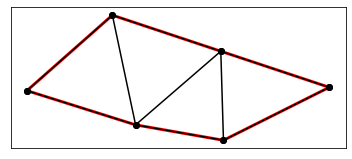

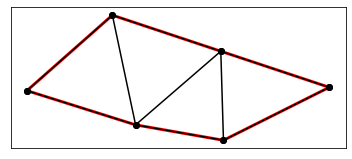

In [152]:
# Comparing NN result with reference mesher


# Get the quality matrix (or connection table from the manuscript) from a random contour

with open('6_contour_20.pkl','rb') as f:
    polygon=pickle.load(f)

procrustes_contour=apply_procrustes(polygon)
procrustes_contour=procrustes_contour.reshape(2*procrustes_contour.shape[0]).reshape(1,-1)

input_contour=Variable(torch.from_numpy(procrustes_contour).type(torch.FloatTensor)).cuda()
predicted_quality_matrix=my_net(input_contour)

predicted_quality_matrix=predicted_quality_matrix.cpu()
predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(nb_of_points,nb_of_points)
procrustes_contour=procrustes_contour.reshape(nb_of_points,2)
ordered_matrix=order_quality_matrix(predicted_quality_matrix,procrustes_contour)
triangulate(procrustes_contour,ordered_matrix)


# Results with reference mesher
fig=plt.figure()
shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
triangulated=triangle.triangulate(shape,'pq0') 
plot.plot(plt.axes(), **triangulated)

initial set edges: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (3, 4)}
Edge: (5, 0) targeting: 4
(5, 0, 4)
Vertex locked: 5
edges inserted: (0, 4)
set of interior edges updated: {(0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (2, 3), (5, 0), (0, 4), (3, 4)}
element inserted: (5, 0, 4)
Edge: (4, 5) targeting: 0
(4, 5, 0)
Element (5, 0, 4) already in set
Edge: (3, 4) targeting: 0
(3, 4, 0)
Vertex locked: 4
edges inserted: (3, 0)
set of interior edges updated: {(3, 0), (0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (3, 0), (2, 3), (5, 0), (0, 4), (3, 4)}
element inserted: (3, 4, 0)
Edge: (2, 3) targeting: 1
(2, 3, 1)
Vertex locked: 2
edges inserted: (3, 1)
set of interior edges updated: {(3, 0), (3, 1), (0, 4)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (3, 0), (3, 1), (2, 3), (5, 0), (0, 4), (3, 4)}
element inserted: (2, 3, 1)
Edge: (1, 2) targeting: 3
(1, 2, 3)
Element (2, 3, 1) already in set
Edge: (0, 1) targeting: 3
Element inserted: (0, 1, 3)
Edge: (0, 1) targeting:

({(0, 1, 3), (2, 3, 1), (3, 4, 0), (5, 0, 4)}, [])

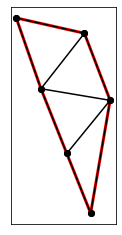

In [149]:
# Triangulation method result (without NN)

original_quality_matrix,_=quality_matrix(procrustes_contour)
ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour,check_for_equal=False)
triangulate(procrustes_contour,ordered_matrix)


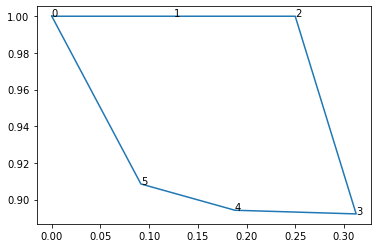

In [153]:
plot_contour(polygon)

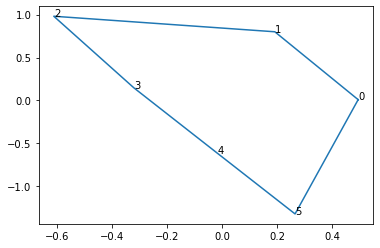

In [151]:
plot_contour(apply_procrustes(polygon))


In [36]:
with open('4_connection_net.pkl','wb') as f:
    pickle.dump(my_net,f)

In [138]:
def apply_procrustes(polygon_points,ref_polygon=None,plot=False):  
    
    # Get reference polygona and adjust any random polygon to that
    if ref_polygon is None:    
        ref_polygon=get_reference_polygon(polygon_points.shape[0])
    
    
    #Mean of each coordinate
    mu_polygon = polygon_points.mean(0)
    mu_ref_polygon = ref_polygon.mean(0)
    
    #Centralize data to the mean 
    centralised_ref_polygon_points = ref_polygon-mu_ref_polygon
    centralised_polygon_points = polygon_points-mu_polygon
    
    #Squared sum of X-mean(X)
    ss_ref_polygon_points = (centralised_ref_polygon_points**2.).sum()
    ss_polygon_points = (centralised_polygon_points**2.).sum()

       
    #Frobenius norm of X
    norm_ss_ref_polygon_points = np.sqrt(ss_ref_polygon_points)
    norm_ss_polygon_points = np.sqrt(ss_polygon_points)

    
    # scale to equal (unit) norm
    centralised_ref_polygon_points /=norm_ss_ref_polygon_points     
    centralised_polygon_points /=norm_ss_polygon_points
        
    
    #Finding best rotation to superimpose on regular triangle
    #Applying SVD to the  matrix 
    A = np.dot(centralised_ref_polygon_points.T, centralised_polygon_points)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V=Vt.T
    R = np.dot(V,U.T)
    
  
    traceTA = s.sum()
    indices=[i for i in range(polygon_points.shape[0])]
    
   

    polygon_transformed =norm_ss_ref_polygon_points*traceTA*np.dot(centralised_polygon_points,R)+mu_ref_polygon

    if plot==True:
        plot_coords=np.vstack([polygon_transformed,polygon_transformed[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return polygon_transformed

In [144]:
def get_apply_procrustes_info(polygon_points,ref_polygon=None,plot=False):  
    
    # Get reference polygona and adjust any random polygon to that
    if ref_polygon is None:    
        ref_polygon=get_reference_polygon(polygon_points.shape[0])
    
    
    #Mean of each coordinate
    mu_polygon = polygon_points.mean(0)
    mu_ref_polygon = ref_polygon.mean(0)
    
    #Centralize data to the mean 
    centralised_ref_polygon_points = ref_polygon-mu_ref_polygon
    centralised_polygon_points = polygon_points-mu_polygon
    
    #Squared sum of X-mean(X)
    ss_ref_polygon_points = (centralised_ref_polygon_points**2.).sum()
    ss_polygon_points = (centralised_polygon_points**2.).sum()

       
    #Frobenius norm of X
    norm_ss_ref_polygon_points = np.sqrt(ss_ref_polygon_points)
    norm_ss_polygon_points = np.sqrt(ss_polygon_points)

    
    # scale to equal (unit) norm
    centralised_ref_polygon_points /=norm_ss_ref_polygon_points     
    centralised_polygon_points /=norm_ss_polygon_points
        
    
    #Finding best rotation to superimpose on regular triangle
    #Applying SVD to the  matrix 
    A = np.dot(centralised_ref_polygon_points.T, centralised_polygon_points)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V=Vt.T
    R = np.dot(V,U.T)
    
  
    traceTA = s.sum()
    indices=[i for i in range(polygon_points.shape[0])]
    
   

    polygon_transformed =norm_ss_ref_polygon_points*traceTA*np.dot(centralised_polygon_points,R)+mu_ref_polygon

    if plot==True:
        plot_coords=np.vstack([polygon_transformed,polygon_transformed[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return polygon_transformed,norm_ss_ref_polygon_points,traceTA,mu_ref_polygon,centralised_polygon_points,R,ref_polygon,norm_ss_polygon_points,mu_polygon

In [146]:
polygon_transformed,norm_ss_ref_polygon_points,traceTA,mu_ref_polygon,centralised_polygon_points,R,ref_polygon,norm_ss_polygon_points,mu_polygon=get_apply_procrustes_info(polygon)

In [142]:
polygon




array([[0.50046029, 0.78376912],
       [0.62844956, 0.78507498],
       [0.69851599, 0.68211702],
       [0.56496005, 0.67675037],
       [0.44078402, 0.67714785],
       [0.32607334, 0.67760114]])

In [147]:
polygon_coords=np.dot((polygon_transformed-mu_ref_polygon)/norm_ss_ref_polygon_points*traceTA,np.linalg.inv(R))*norm_ss_polygon_points+mu_polygon

In [148]:
polygon_coords


array([[0.50664272, 0.76716923],
       [0.60429159, 0.76816553],
       [0.65774848, 0.68961419],
       [0.55585254, 0.68551973],
       [0.46111297, 0.68582299],
       [0.37359494, 0.68616882]])

In [134]:
R

array([[-0.36733937,  0.93008698],
       [ 0.93008698,  0.36733937]])